In [2]:
import torch
import os
import os.path as osp
import torchvision as tv
from glob import glob
from detectron2.data import transforms as T
from torchvision.transforms import functional as tvF
torch.set_grad_enabled(False)
to_pil = tv.transforms.functional.to_pil_image
from collections import defaultdict
from tqdm import tqdm
import torchvision.ops as ops
import torch.nn.functional as F
RGB = tv.io.ImageReadMode.RGB

pixel_mean = torch.Tensor([123.675, 116.280, 103.530]).view(3, 1, 1)
pixel_std = torch.Tensor([58.395, 57.120, 57.375]).view(3, 1, 1)
normalize_image = lambda x: (x - pixel_mean) / pixel_std

def iround(x): return int(round(x))

def resize_to_closest_14x(img):
    h, w = img.shape[1:]
    h, w = max(iround(h / 14), 1) * 14, max(iround(w / 14), 1) * 14
    return tvF.resize(img, (h, w), interpolation=tvF.InterpolationMode.BICUBIC)

root = osp.join(os.path.abspath(''), '..')

In [3]:
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
device = 0

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /home/vhbduy/.cache/torch/hub/main.zip
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
/home/vhbduy/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/vhbduy/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/vhbduy/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /home/vhbduy/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth
100%|██████████| 1.13G/1.13G [03:39<00:00

In [4]:
resize_op = T.ResizeShortestEdge(
                short_edge_length=800,
                max_size=1333,
            )

In [8]:
# reading metas
class2images = {}
for f in glob(osp.join(root, 'datasets/ycb_images/**/*'), recursive=True):
    if osp.isfile(f) and 'mask' not in f:
        image_file = f
        class_name = osp.basename(osp.dirname(f))
        mask_file = osp.splitext(f)[0] + '.mask.png'
        if class_name not in class2images:
            class2images[class_name] = []
        class2images[class_name.strip().lower()].append((image_file, mask_file)) 

In [9]:
classes = sorted(class2images.keys())

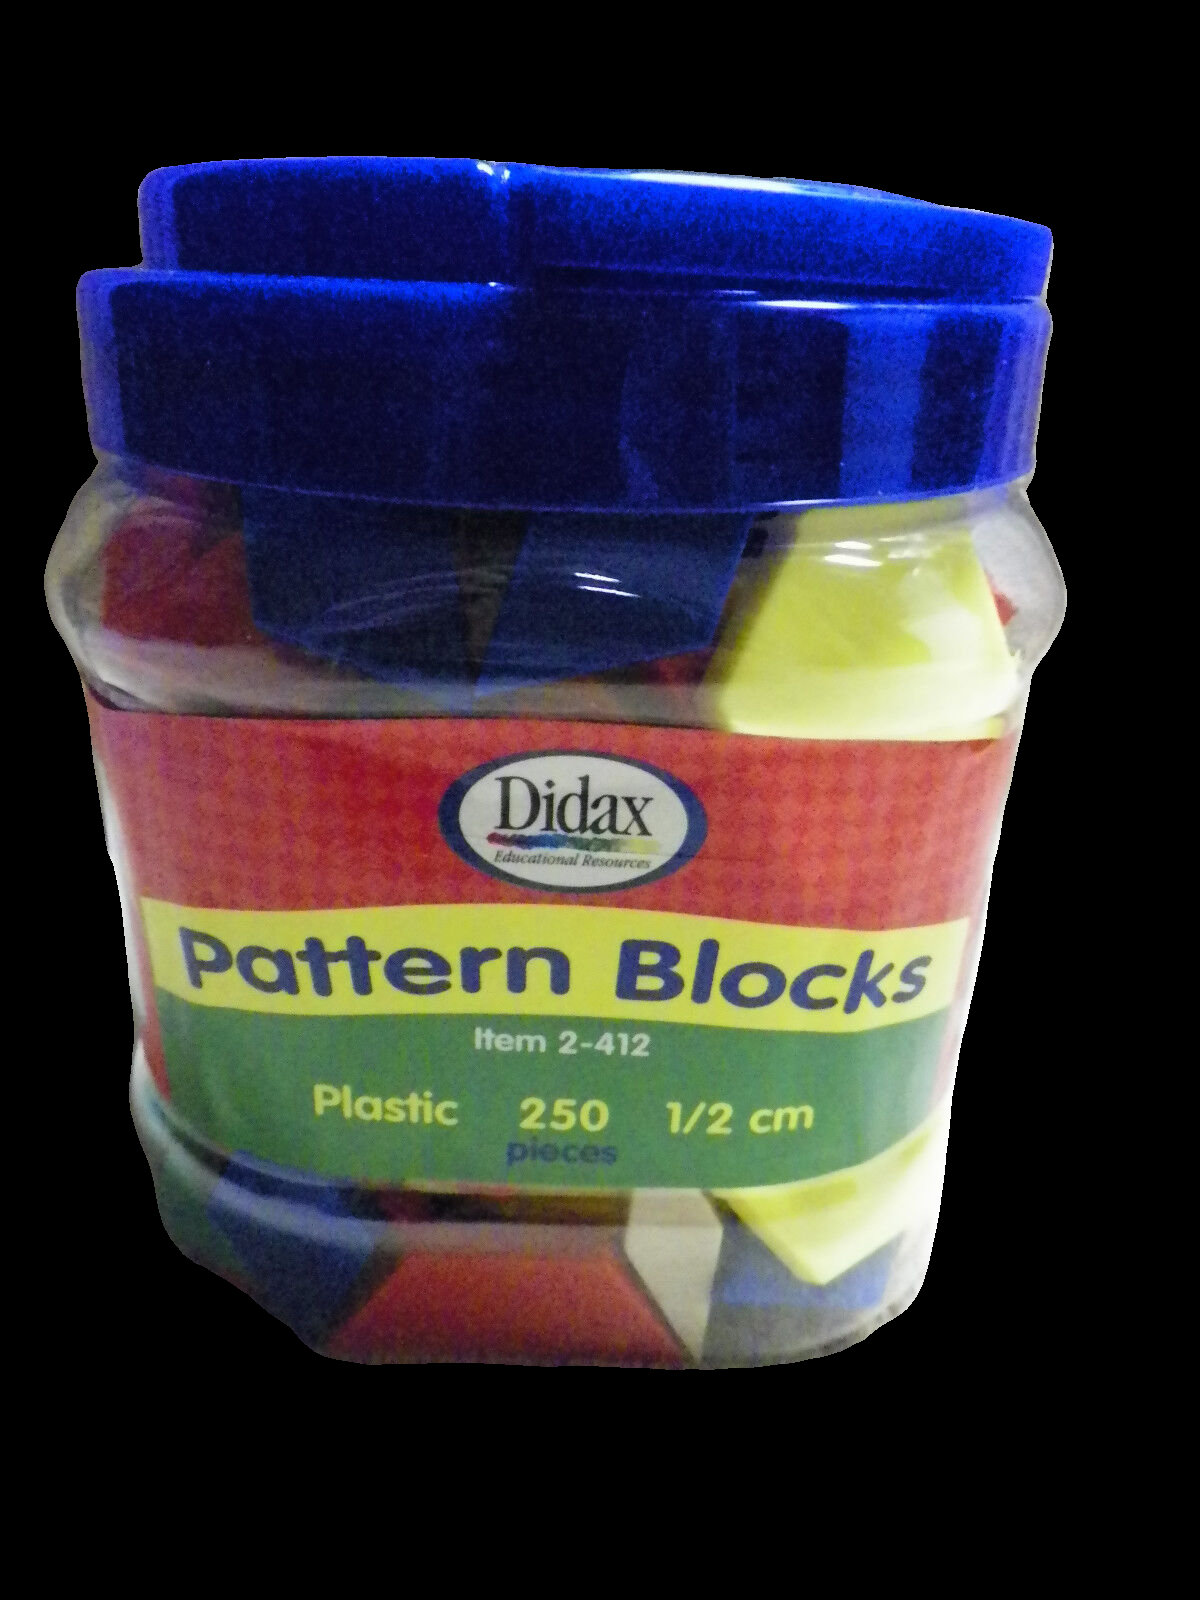

In [10]:
to_pil(tv.io.read_image(image_file, RGB) * (tv.io.read_image(mask_file) != 0).to(torch.uint8))

In [11]:
model = model.to(device)
class2tokens = {}
for cls, images in tqdm(class2images.items()):
    class2tokens[cls] = []
    for image_file, mask_file in images:
        # print(image_file)
        image = tv.io.read_image(image_file, RGB).permute(1, 2, 0)
        resize = resize_op.get_transform(image)
        mask = tv.io.read_image(mask_file).permute(1, 2, 0)

        mask = torch.as_tensor(resize.apply_segmentation(mask.numpy())).permute(2, 0, 1) != 0
        image = torch.as_tensor(resize.apply_image(image.numpy())).permute(2, 0, 1)

        image14 = resize_to_closest_14x(image)
        mask_h, mask_w = image14.shape[1] // 14, image14.shape[2] // 14
        nimage14 = normalize_image(image14)[None, ...]
        r = model.get_intermediate_layers(nimage14.to(device), 
                                return_class_token=True, reshape=True)    
        patch_tokens = r[0][0][0].cpu()
        mask14 = tvF.resize(mask, (mask_h, mask_w))
        if mask14.sum() <= 0.5:
            continue
        avg_patch_token = (mask14 * patch_tokens).flatten(1).sum(1) / mask14.sum()
        class2tokens[cls].append(avg_patch_token) 

  0%|          | 0/34 [00:00<?, ?it/s]/tmp/ipykernel_5139/3589142020.py:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  mask = torch.as_tensor(resize.apply_segmentation(mask.numpy())).permute(2, 0, 1) != 0
100%|██████████| 34/34 [1:35:02<00:00, 167.72s/it]


In [12]:
for cls in class2tokens:
    class2tokens[cls] = torch.stack(class2tokens[cls]).mean(dim=0)

In [13]:
prototypes = F.normalize(torch.stack([class2tokens[c] for c in classes]), dim=1)

In [14]:
classes

['apple',
 'ball',
 'banana',
 'bowl',
 'brick',
 'can',
 'cheez-it',
 'chips',
 'clamp',
 'cleanser bottle',
 'coffee jar',
 'comet pine',
 'cups',
 'drill',
 'glass',
 'lego',
 'lemon',
 'marker',
 'mini soccer',
 'mug',
 'mustard',
 'orange',
 'peach',
 'pear',
 'peg-hole',
 'pitcher',
 'plate',
 'screwdriver',
 'skillet',
 'spray bottle',
 'sugar box',
 'toy airplane box',
 'utensil',
 'wood blocks jar']

In [17]:
len(classes)

34

In [16]:
prototypes.shape

torch.Size([34, 1024])

In [18]:
category_dict = {
    'prototypes': prototypes,
    'label_names': classes
}

In [19]:
torch.save(category_dict, 'ycb_prototypes_2.pth')